In [2]:
# Import
# Math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
import random
from scipy.stats import norm
import scipy.optimize as optimize
import time
import math as m

# Ez parallelization
from joblib import Parallel, delayed

# File Handling
from sys import getsizeof
import _pickle as pickle
# Alternatively use JSON which will be human readable
# import json

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Custom imports
from MarketGeneratingFunctions.global_cache import Global_Cache
import MarketGeneratingFunctions.base_from_gen as bg
import MarketGeneratingFunctions.pricing_func as pf
from path_datatype import Path

## If generate data

In [21]:
# C magic?
#from numba import jit

"""
The Goal of this File is to generate a bunch of sample paths for the value of our tracked market through 30 years

I'm setting the preliminary goal of around 1600 paths per hour since this gives us a reasonably fast
rate (We can get a testable set in about an hour, and a set that should be large enough to be useable over 
a day 24*1600 = 38400 paths)

At the latest point I ran it for 1600 paths in 3926 seconds ie, 65 minutes. 

----------- What are we finding and saving -----------
We need to at all times know the value of our hedging instruments, these will be (as I understand it)
r_t,
Q(T_i > tau)_t           for i in 1 to 30
Alternatively 
Swaption(T_i,T_end)_t    for i in 1 to 30
Q(T_i > tau)_t           for i in 1 to 30
Alternatively 
Swap(T_i, T_end)_t
Q(T_i > tau)_t           for i in 1 to 30

We also need the value of the CVA at every timepoint 
CVA_t

And we might as well include the default intensity since we know it, so it's only taking up whatever the write
/ read time is for one parameter, and we might want to hedge in it idk.


----------- How are we Saving it -----------
While grasping the data a dataframe is a natural choice, alternatively as in the demos a numpy matrix,
to save it, preliminarily CSV feels like a natural choice but I need to think about it. Pickle is also a choice


----------- How can we get speedups -----------
The first and most important speedup in my eyes is that we can pre-calculate certain elements that remain unchanged
across runs. For instance rstar(t), A(t,T) and B(t,T) are all unchanged no matter when or where they are evaluated. 
Some of these are acsessed literally thousands of times per run, and over thousands of runs that means millions of 
evaulations, a dict has (loosely speaking) O(1) search which should be much faster than the function evaluation

The Second speedup is making sure that run specific elements are re-used as efficiently as possible. If we let each 
run occupy it's own thread we can let them share these local elements, which again saves unnessecary recalculation,
examples of where we can do this is for instance P(t,T,rt) which does depend on an observed interest rate, but will
likely occur multiple times, or the ZCB values which are time step dependant but called by many Swaptions.

Finally the last speedup is to use multithreading to wrap the above. With all of these in play it should be possible
to efficiently generate our paths 
"""

########################################################
## Defining Global Params and info                    ##
########################################################
# Set parameters
params = dict()

params["t0"] = t0 = 0
params["T"] = T = 10

# Intensity params
params["lambda0"] = lambda0 = 0.01
params["mu"] = mu = 0.01
params["kappa"] = kappa = 1
params["v"] = v = 0.1

params["j_alpha"] = j_alpha = T/4 # We should expect to see about 4 jumps,
params["gamma"] = gamma = mu/5 # With expected size mu/5

# Short rate params
params["r0"] = r0 = 0.045
params["alpha"] = alpha = 1
params["theta"] = theta = r0*alpha
params["sigma"] = sigma = np.sqrt(r0)/5

# Covariance
params["rho"] = 0.8

# Number of steps and Number of Paths total
params["N"] = N = (T-t0)*128
N_paths = 200

# Global base time grid, pre jump insertion
t_s_base = np.linspace(t0,T,N)
T_s = np.arange(0,11,1)

#########################################
## Define Globally shareable Caches    ##
#########################################
# Finding K at startup, maybe put this in the global cache file?
gc = Global_Cache(t_s_base,T_s,params)
K = gc.K

#for pathN in range(0,N_paths):
def process(pathN):
    # Generate the market grid and basic r and lambda
    [t_s,r,lambdas,r_ongrid,lambdas_ongrid] = bg.mkt_base_from_grid(t_s_base,params)
    # Create a pricing object for this specific market
    pricer = pf.PricingFunc(params, gc, t_s, r, r_ongrid,lambdas, lambdas_ongrid)
    
    Q_s = [[pricer.Q(t,T) for t in t_s] for T in T_s]   # Here there must be room for performance improvement? These lists could be pre-allocated or something since we know that it's going to be a list of a list of floats, same for below??
    Swaptions = [[pricer.swaption_price(t,T_s_2,K) for t in t_s] for T_s_2 in [T_s[i:] for i in range(0,len(T_s)-1)]] # Maybe we could C compile this file? Should be a huge performance increase, but might be a headache since we need to track down and type hint everything
    CVA = [pricer.CVA(t,T_s,K) for t in t_s]
    #Swaps = [[pricer.swap_price(t,T_s_2,K) for t in t_s] for T_s_2 in [T_s[i:] for i in range(0,len(T_s)-1)]]

    return Path(t_s, lambdas, r, CVA, Q_s, None, Swaptions)

strt = time.time()
paths = Parallel(n_jobs = 4)(delayed(process)(pathN) for pathN in range(0,N_paths)) 
end_time = time.time()

print("Total Time: %s" %(end_time - strt))
print("Average Time Per Path %s: " %((end_time - strt)/N_paths))

with open("200RunDemo.pkl","wb") as fp:
    pickle.dump(paths,fp)

Total Time: 577.1019620895386
Average Time Per Path 2.885509810447693: 


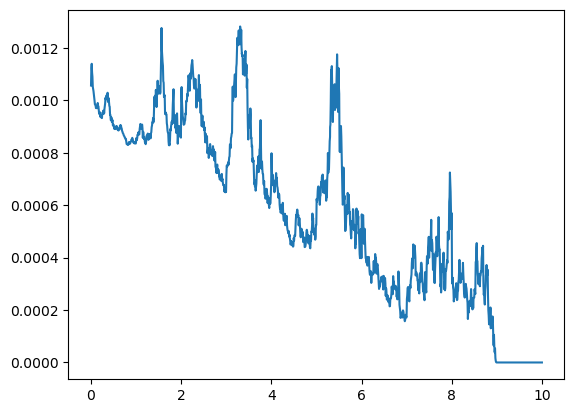

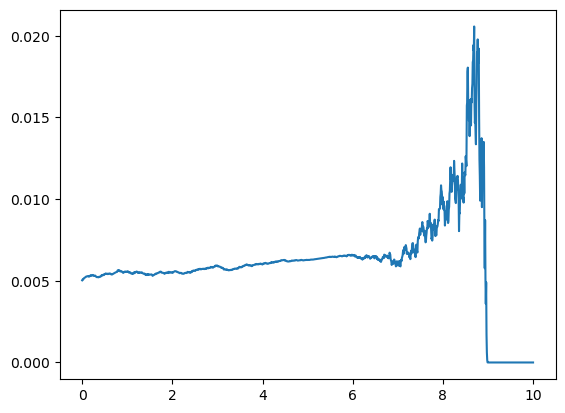

In [23]:
plt.plot(paths[0].t_s,paths[0].CVA)
plt.show()
plt.plot(paths[0].t_s,paths[0].Swaptions[9])
plt.show()
#plt.plot(paths[0].t_s,paths[0].Swaps[0])


In [53]:
## Load File
with open("1.6kRunDemo.pkl","rb") as fp:
    paths = pickle.load(fp)


## If use data file

## Without hedge

2100800
2100800


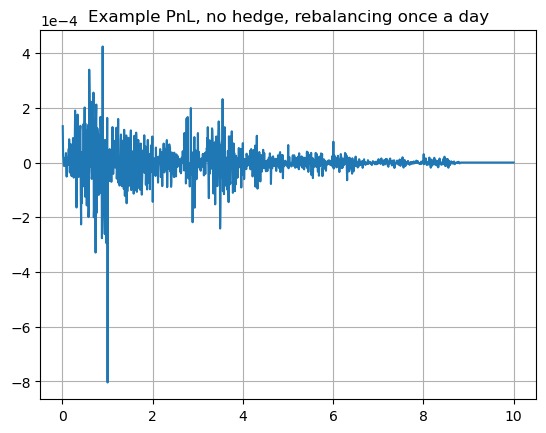

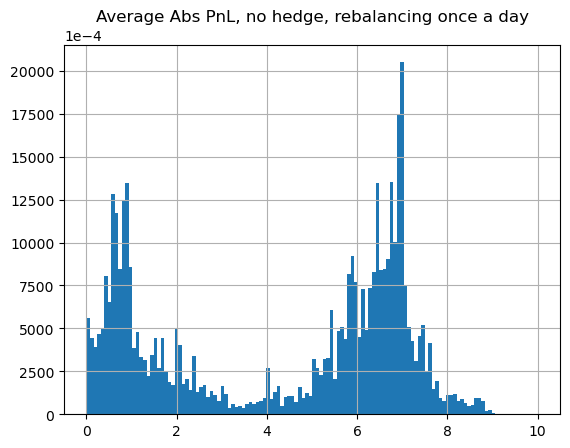

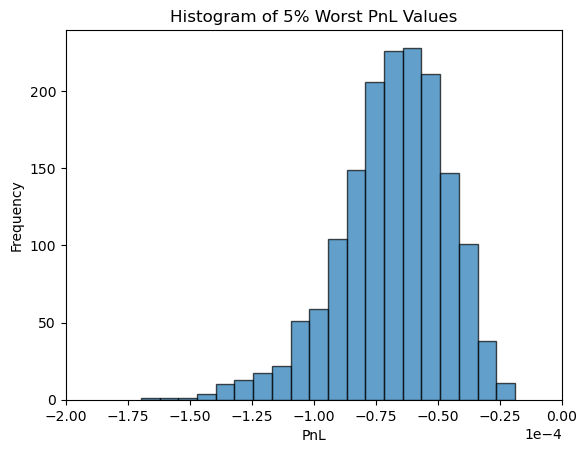

In [56]:
def pnl_cva(path):
    pnl_without_hedge = np.zeros(len(path.CVA)-1)
    for i in range(1, len(path.CVA)):
        pnl_without_hedge[i-1] = path.CVA[i]-path.CVA[i-1]
    return pnl_without_hedge

pnl_without_hedge = [None]*len(paths)
for i in range(len(pnl_without_hedge)):
    pnl_without_hedge[i] = pnl_cva(paths[i])



plt.figure(1)
plt.title("Example PnL, no hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(paths[3].t_s[1:],pnl_without_hedge[3])

plt.figure(2)
plt.title("Stacked Abs PnL, no hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
stacked_times = [t for t in paths[i].t_s[1:] for i in range(len(paths))]
print(len(stacked_times))
stacked_abs_pnL = [abs(pnl) for pnl in pnl_without_hedge[i] for i in range(len(paths))]
print(len(stacked_abs_pnL))
plt.hist(stacked_times, weights=stacked_abs_pnL,bins=128)


plt.figure(3)
# Extract the 5% worst percentile values from each array
var_values_no_hedge = np.array([np.percentile(p, 5) for p in pnl_without_hedge]) # is this really VaR?
# Plot histogram
plt.hist(var_values_no_hedge, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("PnL")
plt.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
plt.ylabel("Frequency")
plt.xlim(-0.0002,0)
# plt.xlim(min(worst_5_percent_values)*2, max(worst_5_percent_values)-min(worst_5_percent_values))
plt.title("Histogram of 5% Worst PnL Values")
plt.show()


## Delta hedge


In [ ]:
def delta_hedge(path):
    pnl = np.zeros(len(path.CVA)-1)
    default_buckets = [np.array(path.Q_s[k-1]) - np.array(path.Q_s[k]) for k in range(1, len(path.Q_s))]
    for i in range(1, len(path.CVA)):
        delta_CVA = path.CVA[i]- path.CVA[i-1]
        quantity_swapt = sum(default_buckets[k][i]*(path.Swaptions[k][i]-path.Swaptions[k][i-1]) for k in range(0,len(default_buckets)) if k > path.t_s[i])
        quantity_defaultprob = sum(path.Swaptions[k][i]*(path.Swaptions[k][i]-path.Swaptions[k][i-1]) for k in range(0,len(default_buckets)) if k > path.t_s[i])
        pnl[i-1] = delta_CVA - (quantity_swapt + quantity_defaultprob)
    return pnl

def Odelta_hedge(path):
    pnl = np.zeros(len(path.CVA)-1)
    for i in range(len(path.CVA)-1):
        t = path.t_s[i]
        Q = [path.Q_s[j][i] for j in range(0,11)]
        Swapts = [path.Swaptions[j][i] for j in range(0,10)]
        T_sl = T_s.copy()
        T_sl = [T_sl[i] for i in range(len(T_sl)-1) if T_sl[i+1] > t] + [T_sl[-1]]

        if len(T_sl) <= 2:
            pnl[i] = 0 

        else: 
            Q_vec = [Q[T] for T in T_sl] # Q from T_a to T_b
            croppedSwapts = [Swapts[T] for T in T_sl[:-1]] # Swaptions from T_a to T_b-1

            SwapHedgeAmount = [(Q_vec[k-1] - Q_vec[k])  for k in range(1,len(T_sl))] 

            Swapts0 = croppedSwapts + [0.0]                         # Zero padded swaptions so that we can loop over a sum of swaptions
            QHedgeAmount = [0] + [Swapts0[k] - Swapts0[k-1] for k in range(1,len(T_sl))]   # How much to hedge in Q starting at indx a and ending at Q(T_b-1)

            # Adjustment term
            if t > T_s[0]: 
                SwapHedgeAmount[0] = 0
                SwapHedgeAmount[1] = (1 - Q_vec[2])
            
                QHedgeAmount[1] = 0
                QHedgeAmount[2] = -Swapts0[1] + Swapts0[2]
                QHedgeAmount[0] = Swapts0[1]# Just for value balance, since Q0 never moves this has no effect on the efficacy of the hedge, but balances the books s.t the delta hedge costs exactly twice the value of the CVA
                                            # It comes from that we have a (1 - Q2)*(Swapts(T_1,T_b)) so the one is replaced by Q[0] so we use stuff on market instead of holding numbers / saved cash
            SwaptCost = np.inner(croppedSwapts,SwapHedgeAmount)
            QCost = np.inner(QHedgeAmount,Q_vec)

            futureSwapts = [path.Swaptions[j][i+1] for j in range(0,10)]
            futureSwapts = [futureSwapts[T] for T in T_sl[:-1]]
            futureQ = [path.Q_s[j][i+1] for j in range(0,11)]
            futureQ_vec = [futureQ[T] for T in T_sl[:]]

            SwaptValue = np.inner(futureSwapts,SwapHedgeAmount)
            QValue = np.inner(QHedgeAmount,futureQ_vec)
            
            cost = SwaptCost + QCost
            #print(cost/2 - path.CVA[i])
            value = (SwaptValue + QValue)

            pnl[i] = ((path.CVA[i+1] - path.CVA[i]) - (value - cost))
    return pnl
    


In [28]:
print(Odelta_hedge(paths[3]))

-5.27605303196621e-14
6.505213034913027e-19
6.505213034913027e-19
2.168404344971009e-19
-6.505213034913027e-19
0.0
-8.673617379884035e-19
6.505213034913027e-19
2.168404344971009e-19
0.0
2.168404344971009e-19
2.168404344971009e-19
-4.336808689942018e-19
2.168404344971009e-19
-6.505213034913027e-19
6.505213034913027e-19
0.0
0.0
-4.336808689942018e-19
-8.673617379884035e-19
-2.168404344971009e-19
2.168404344971009e-19
0.0
2.168404344971009e-19
4.336808689942018e-19
4.336808689942018e-19
8.673617379884035e-19
6.505213034913027e-19
6.505213034913027e-19
0.0
2.168404344971009e-19
6.505213034913027e-19
0.0
-4.336808689942018e-19
2.168404344971009e-19
-4.336808689942018e-19
2.168404344971009e-19
2.168404344971009e-19
-4.336808689942018e-19
-2.168404344971009e-19
0.0
0.0
2.168404344971009e-19
-2.168404344971009e-19
0.0
-2.168404344971009e-19
4.336808689942018e-19
-2.168404344971009e-19
-2.168404344971009e-19
-2.168404344971009e-19
2.168404344971009e-19
4.336808689942018e-19
0.0
0.0
4.3368086899

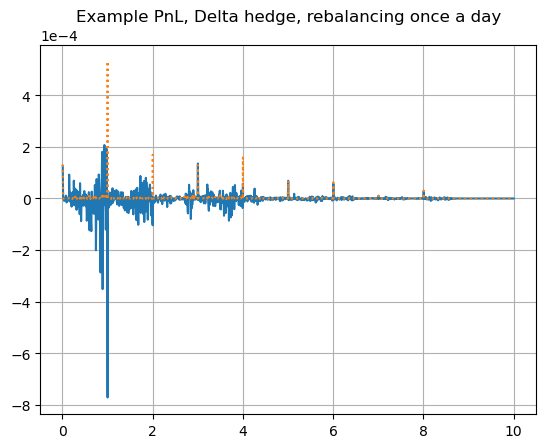

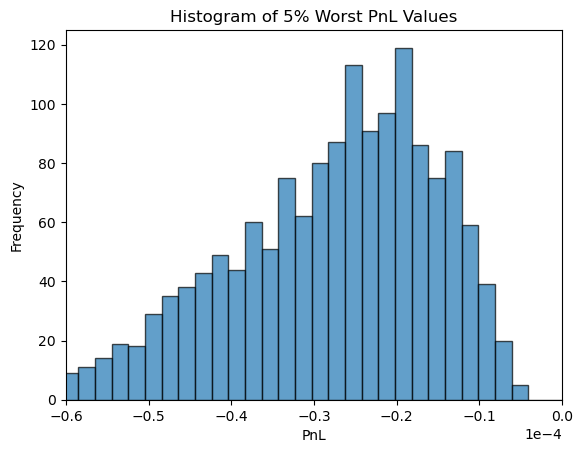

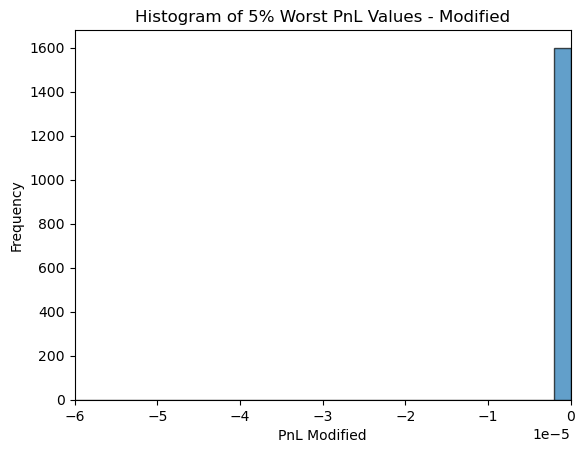

(array([2.41032068e-01, 1.34193607e-02, 6.28352910e-03, 1.14036728e-02,
        1.19985228e-02, 2.53312549e-02, 1.37616827e-02, 3.83716283e-02,
        3.66796105e-02, 1.47935969e-02, 2.49432723e-02, 5.51535777e-02,
        3.39931104e-01, 8.11232338e-03, 1.10982771e-02, 6.18410717e-03,
        5.41052728e-03, 5.11326972e-03, 1.32491278e-02, 1.47721779e-02,
        5.13039418e-03, 1.41828239e-02, 6.94769502e-03, 3.86597647e-03,
        2.56753649e-03, 2.07552289e-01, 9.38171092e-03, 2.80350520e-03,
        2.48827058e-03, 1.27697723e-03, 1.05417446e-02, 2.06508624e-03,
        3.74461738e-03, 3.21809844e-03, 1.03406308e-03, 2.37277678e-03,
        1.55321294e-03, 7.72298020e-04, 6.24007319e-02, 2.74086062e-03,
        5.60416517e-04, 7.53372849e-04, 3.53161085e-04, 2.69069639e-04,
        1.86089864e-04, 5.94294276e-04, 2.74024614e-04, 4.66317842e-04,
        4.57674570e-04, 4.46050394e-04, 5.52462192e-04, 8.66803165e-02,
        1.02156838e-03, 2.54087650e-03, 2.28399633e-03, 4.895443

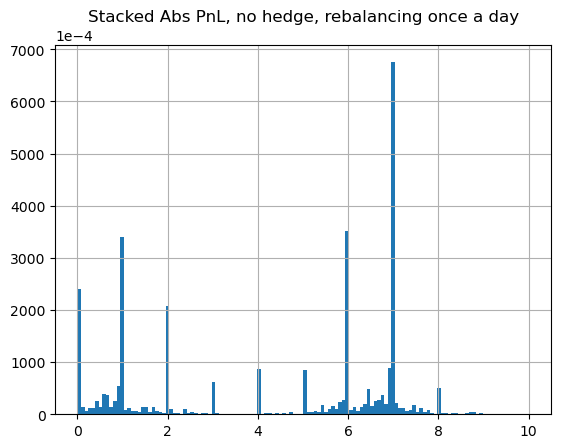

In [ ]:

pnl = [None] * len(paths) #[np.zeros(len(paths[1].CVA)-1) for _ in range(len(paths))]
pnl_modified = [None] * len(paths)
for i in range(len(pnl)): 
    pnl[i] = delta_hedge(paths[i])
    pnl_modified[i] = Odelta_hedge(paths[i])

plt.figure(1)
plt.title("Example PnL, Delta hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(paths[3].t_s[1:],pnl[3])
plt.plot(paths[3].t_s[1:],pnl_modified[3], linestyle = ':')

plt.figure(2)
plt.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
# Extract the 5% worst percentile values from each array
var_values_hedge = np.array([np.percentile(p,5) for p in pnl]) #BHS VaR
var_values_hedge2 = np.array([np.percentile(p,5) for p in pnl_modified]) #BHS VaR
bins = np.histogram(np.hstack((var_values_hedge,var_values_hedge2)), bins = 60)[1]
# Plot histogram
# plt.hist(worst_5_percent_values, bins=20, edgecolor='black', alpha=0.7)
plt.hist(var_values_hedge, bins, edgecolor='black', alpha=0.7)
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.xlim(-.6*1e-4, 0.0) #min(worst_5_percent_values)*2
plt.title("Histogram of 5% Worst PnL Values")
plt.show()


plt.hist(var_values_hedge2, bins, edgecolor='black', alpha=0.7)
plt.xlabel("PnL Modified")
plt.ylabel("Frequency")
plt.xlim(-.6*1e-4, 0.0) #min(worst_5_percent_values)*2
plt.title("Histogram of 5% Worst PnL Values - Modified")
plt.show()

plt.figure(3)
plt.title("Stacked Abs PnL, Modified Delta Hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
stacked_times = [t for t in paths[i].t_s[1:] for i in range(len(paths))];
stacked_abs_pnL = [abs(pnl) for pnl in pnl_modified[i] for i in range(len(paths))];
plt.hist(stacked_times, weights=stacked_abs_pnL,bins=128);